In [1]:
# Импорт библиотек
import os
import time
import cotel
import GTU
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# Основные константы
calctolerance = 10**-3
calcmethod = "hybr"
KPDnasos = 0.8074
KPD = 0.99

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)


# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)


# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure= gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


####################################################################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.loc["GTU", "N"] = Gas_turbine_res["N"]
electric.loc["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.loc["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.loc["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.loc["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.loc["GTU-KU", "P"] = 0.1
Gas_turbine_composition=pd.read_excel("input.xlsx", sheet_name="Gas_composition0", index_col=0)


#Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.loc["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"]=Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)

# # Задание энтальпий газа в рабочем режиме
# Temperatures = gas_streams.loc["GTU-KU":"GPK-out", "T"]
# Pressure= gas_streams.loc["GTU-KU", "P"]
# Enthalpies = list(map(lambda x: gas1.p_t(Pressure, x)["h"], Temperatures))
# gas_streams.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

####################################################################################################
# расчет котла целиком
Whole_cotel = cotel.cotel_all(
    KPD,
    KPDnasos,
    calctolerance*10**1,
    gas0,
    gas1,
    water,
    calcmethod,
    gas_streams0,
    water_streams0,
    gas_streams,
    water_streams,
    heaters,
    electric
)
Whole_cotel.calc(maxiterations=50)


Whole_cotel = cotel.cotel_all(
    KPD,
    KPDnasos,
    calctolerance,
    gas0,
    gas1,
    water,
    calcmethod,
    gas_streams0,
    water_streams0,
    gas_streams,
    water_streams,
    heaters,
    electric
)
Whole_cotel.calc(maxiterations=50)


print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"],
              water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"],
              water_streams.at["GPK-IND", "H"])["Q"],
)

dQ/Q ПЕВД+ИВД+ЭВД -5.990448030139583
dQ/Q ПЕВД+ИВД+ЭВД 3.778385224406701
dQ/Q ПЕВД+ИВД+ЭВД -2.400361353953893
dQ/Q ПЕВД+ИВД+ЭВД 1.4623791008275675
dQ/Q ПЕВД+ИВД+ЭВД -1.0134512629433103
dQ/Q ПЕВД+ИВД+ЭВД 0.702065860637345
dQ/Q ПЕВД+ИВД+ЭВД -0.4745860937451818
dQ/Q ПЕВД+ИВД+ЭВД 0.3289419303742058
dQ/Q ПЕВД+ИВД+ЭВД -0.25783258692759103
dQ/Q ПЕВД+ИВД+ЭВД 0.1994303179434871
dQ/Q ПЕВД+ИВД+ЭВД -0.1429823941118843
dQ/Q ПЕВД+ИВД+ЭВД 0.11552059009852526
dQ/Q ПЕВД+ИВД+ЭВД -0.07946500798472574
dQ/Q ПЕВД+ИВД+ЭВД 0.04087207870267
dQ/Q ПЕВД+ИВД+ЭВД -0.026091574128112877
dQ/Q ПЕВД+ИВД+ЭВД 0.029845250600440753
dQ/Q ПЕВД+ИВД+ЭВД -0.03365158850464407
dQ/Q ПЕВД+ИВД+ЭВД 0.03618064463936017
dQ/Q ПЕВД+ИВД+ЭВД -0.037896160152088895
dQ/Q ПЕВД+ИВД+ЭВД 0.0390226674571425
dQ/Q ПЕВД+ИВД+ЭВД -0.027445654123567247
dQ/Q ПЕВД+ИВД+ЭВД 0.0183843361524252
dQ/Q ПЕВД+ИВД+ЭВД -0.012319089493347143
dQ/Q ПЕВД+ИВД+ЭВД -0.004097580737837682
dQ/Q ППНД+ИНД+ГПК -10.969605271116176
dQ/Q ППНД+ИНД+ГПК 1.4513939353632523
dQ/Q ППНД+ИНД

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.869199,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,466.094461,0.1,871.817044,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,287.202587,0.1,673.473270,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,217.643571,0.1,598.509073,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,214.987457,0.1,595.667793,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,159.570024,0.1,536.704569,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,96.450392,0.1,470.182022,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
PEVD-DROSVD,515.572030,5.747000,3462.823363,63.477740,NaN,NaN
IVD-PEVD,278.208166,6.244934,2781.859504,63.477740,NaN,NaN
EVD-IVD,277.602144,6.244934,1224.348909,63.477740,NaN,NaN
PEN-EVD,149.981454,6.244934,635.679183,63.477740,NaN,NaN
BND-PEN,149.005575,0.463607,627.889903,63.477740,NaN,NaN
PPND-DROSND,196.143159,0.457000,2849.839501,13.474243,NaN,NaN
IND-PPND,149.005575,0.463607,2744.726001,13.474243,NaN,NaN
GPK-IND,146.382470,0.463607,616.607747,76.951983,NaN,NaN
GPK-REC,146.382470,0.463607,616.607747,90.832903,NaN,NaN


In [4]:
water_streams0['PEVD-DROSVD':'REC-GPK']

,T,P,H,G,S
PEVD-DROSVD,511.500000,8.4070,3423.209978,63.40,NaN
IVD-PEVD,301.297556,8.7460,2747.104023,63.40,NaN
EVD-IVD,298.800000,8.7460,1337.948265,63.40,NaN
PEN-EVD,166.500000,8.7460,708.319849,63.40,NaN
BND-PEN,164.738361,0.6964,696.095567,63.40,NaN
PPND-DROSND,211.600000,0.6910,2871.481837,14.76,NaN
IND-PPND,164.738361,0.6964,2762.534980,14.76,NaN
GPK-IND,164.600000,0.6964,695.493701,78.16,NaN
GPK-REC,164.600000,0.6964,695.493701,82.91,NaN
REC-GPK,60.000000,0.6964,251.748396,82.91,NaN


In [5]:
Errors_water= abs(water_streams.loc['PEVD-DROSVD':'REC-GPK','T':'G'] -water_streams0.loc['PEVD-DROSVD':'REC-GPK','T':'G'])/water_streams0.loc['PEVD-DROSVD':'REC-GPK','T':'G']*100
Errors_water

,T,P,H,G
PEVD-DROSVD,0.796096,31.640300,1.157200,0.122618
IVD-PEVD,7.663318,28.596680,1.265168,0.122618
EVD-IVD,7.094329,28.596680,8.490564,0.122618
PEN-EVD,9.921049,28.596680,10.255348,0.122618
BND-PEN,9.550166,33.428093,9.798319,0.122618
PPND-DROSND,7.304745,33.863965,0.753699,8.711088
IND-PPND,9.550166,33.428093,0.644661,8.711088
GPK-IND,11.067758,33.428093,11.342440,1.545569
GPK-REC,11.067758,33.428093,11.342440,9.556028
REC-GPK,0.000000,33.428093,0.077647,9.556743


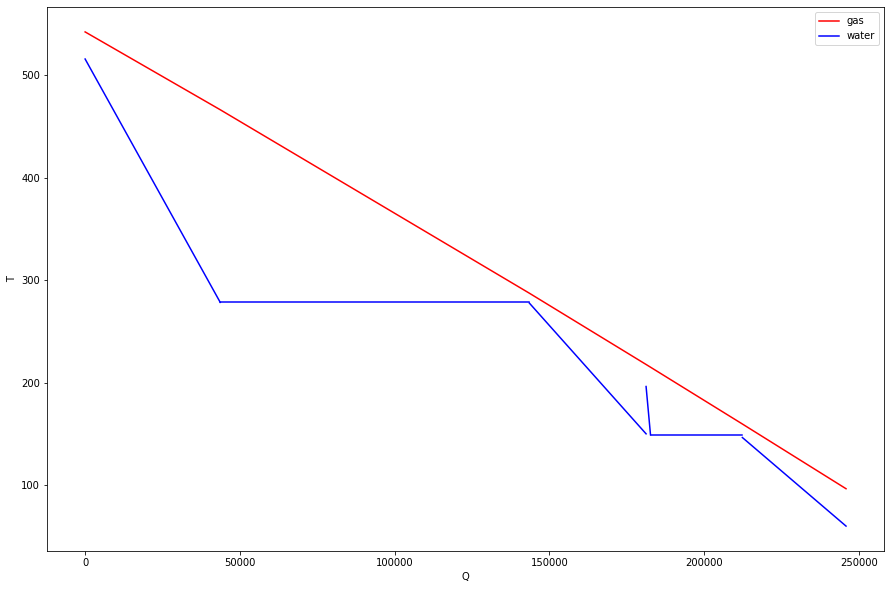

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
Qg =[0,
    heaters.loc['PEVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg']+heaters.loc['GPK','Qg']
    ]
Qw =[0,
    heaters.loc['PEVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg']+heaters.loc['GPK','Qg']
    ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out','T']
Tw = [water_streams.loc['PEVD-DROSVD','T'],
      water_streams.loc['IVD-PEVD','T'],
      water_streams.loc['IVD-PEVD','T'],
      water_streams.loc['EVD-IVD','T'],
      water_streams.loc['PEN-EVD','T'],
      water_streams.loc['PPND-DROSND','T'],
      water_streams.loc['IND-PPND','T'],
      water_streams.loc['IND-PPND','T'],
      water_streams.loc['GPK-REC','T'],
      water_streams.loc['REC-GPK','T'],
     ]
plt.plot(Qg,Tg, color = 'red')
plt.plot(Qw[0:2],Tw[0:2], color = 'blue')
plt.plot(Qw[1:3],Tw[1:3], color = 'blue')
plt.plot(Qw[3:5],Tw[3:5], color = 'blue')
plt.plot(Qw[5:7],Tw[5:7], color = 'blue')
plt.plot(Qw[6:8],Tw[6:8], color = 'blue')
plt.plot(Qw[8:10],Tw[8:10], color = 'blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas','water'])
plt.show()